## 基于Tensorflow实现交通标志识别

构建交通标志识别深度学习模型，目标是建立一个模型，可以检测和分类从移动的汽车取得的视频流中的交通标志。

In [1]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Allow image embeding in notebook
%matplotlib inline

## 数据集

 http://btsd.ethz.ch/shareddata/ 
 
- BelgiumTSC_Training (171.3MBytes)
- BelgiumTSC_Testing (76.5MBytes)

上面两个目录中的每一个都有62个子目录，从00000到00062顺序命名。目录名称代表代码（或标签），目录中的图像是该标签的示例。

## 解析和加载训练数据

In [4]:
def load_data(data_dir):
    """
    加载数据集
    
    imgages:Numpy arrays 列表，每一个数组代表一张图像
    labels:标签数字列表，每一个代表图像标签
    """
    
    # 获取所有子目录，每一个代表一个标签
    directories=[d for d in os.listdir(data_dir)
                if os.path.isdir(os.path.join(data_dir,d))]
    
    # 遍历标签路径，构建images和lables
    labels=[]
    images=[]
    for d in directories:
        label_dir=os.path.join(data_dir,d)
        file_names=[os.path.join(label_dir,f)
                   for f in os.listdir(label_dir) if f.endswith('.ppm')]
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images,labels

# 加载数据
ROOT_PATH='data/BelgiumTSC/'
train_data_dir=os.path.join(ROOT_PATH,'Training')
test_data_dir=os.path.join(ROOT_PATH,'Testing')

images, labels = load_data(train_data_dir)

我们将会得到两个列表
- imgages:Numpy arrays 列表，每一个数组代表一张图像
- labels:标签数字列表，每一个代表图像标签

## 探索数据集

In [5]:
print("Unique Labels:{0}\n Total Images：{1}".format(len(set(labels)),len(images)))

Unique Labels:62
 Total Images：4575


展示每个类别的第一张图片

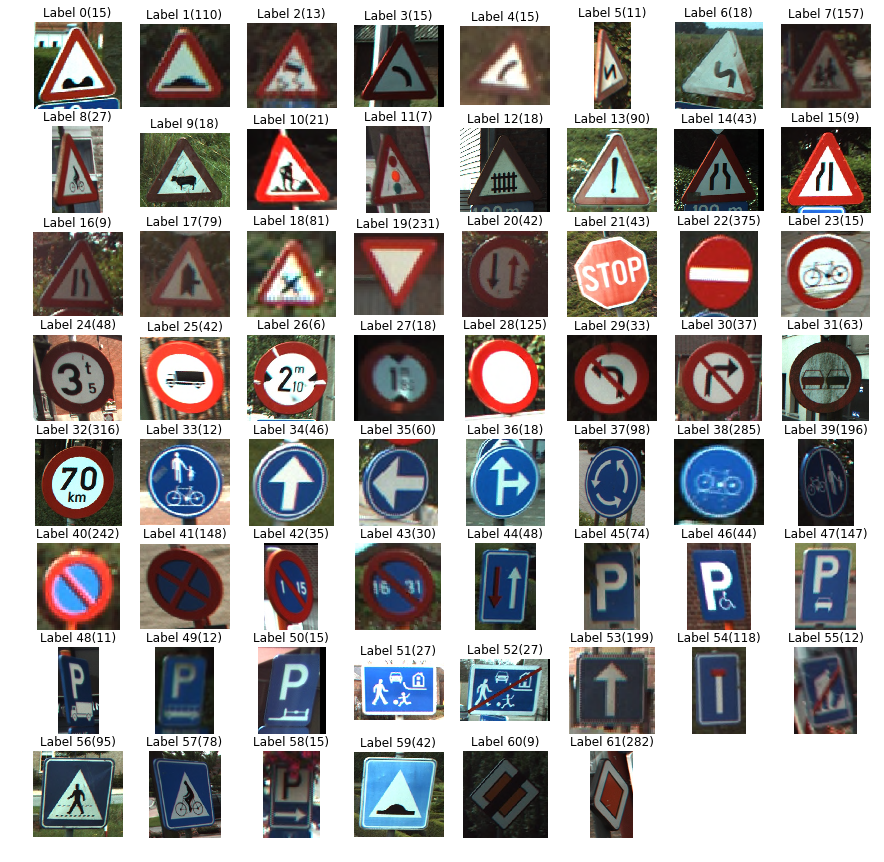

In [6]:
def display_images_and_labels(images,labels):
    """
    """
    unique_labels=set(labels)
    plt.figure(figsize=(15,15))
    i=1
    for label in unique_labels:
        image=images[labels.index(label)]
        plt.subplot(8,8,i)
        plt.axis("off")
        plt.title("Label {0}({1})".format(label,labels.count(label)))
        i+=1
        plt.imshow(image)
    plt.show()
display_images_and_labels(images,labels)

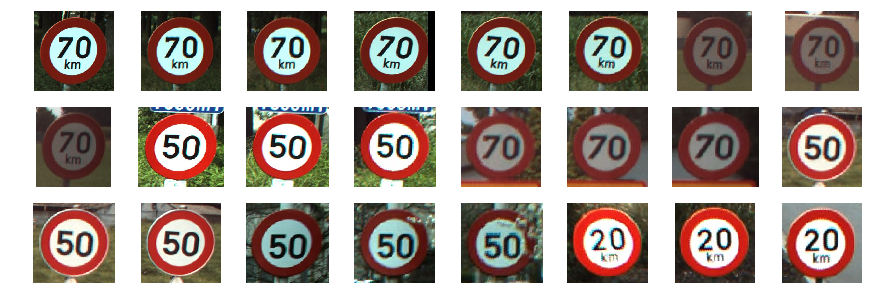

In [7]:
def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images, 32)

## 处理不同尺寸的图片

In [8]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (141, 142, 3), min: 0, max: 255
shape: (120, 123, 3), min: 0, max: 255
shape: (105, 107, 3), min: 0, max: 255
shape: (94, 105, 3), min: 7, max: 255
shape: (128, 139, 3), min: 0, max: 255


可以发现图片大小差不多在128x128左右，我们为了加快模型训练，我们将图片缩放到32x32

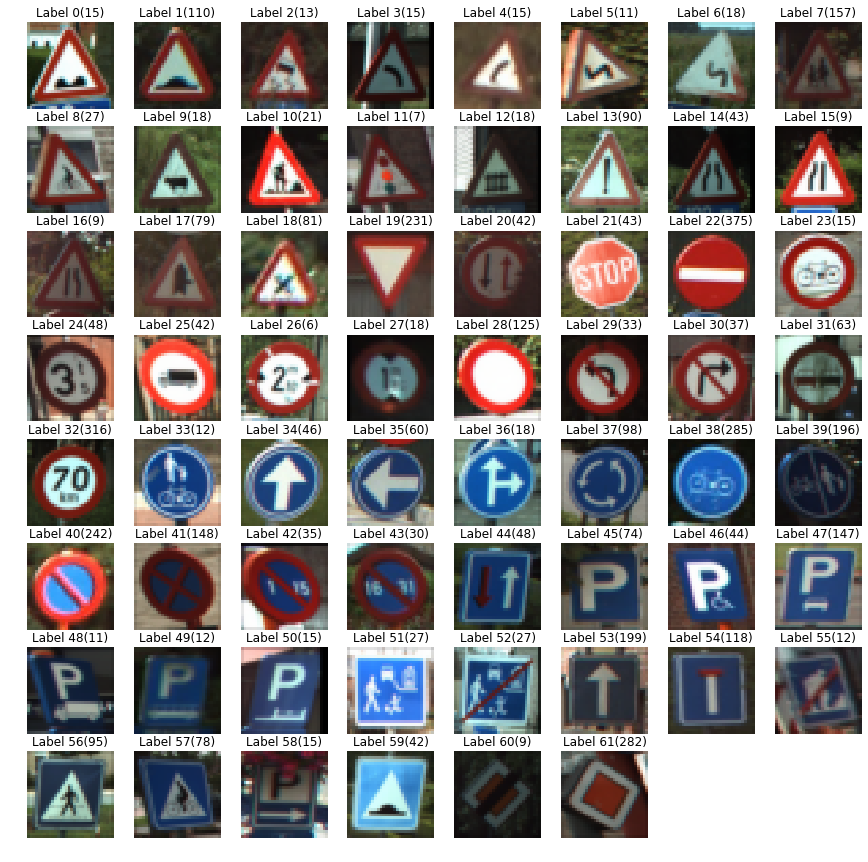

In [9]:
# Resize images
images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                for image in images]
display_images_and_labels(images32, labels)

## 简单模型

In [11]:
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

labels:  (4575,) 
images:  (4575, 32, 32, 3)


全连接层：全连接神经网络(fully connected neural network)，顾名思义，就是相邻两层之间任意两个节点之间都有连接。全连接神经网络是最为普通的一种模型（比如和CNN相比），由于是全连接，所以会有更多到权重值和连接，因此也意味着占用更多到内存和计算。
![](https://img-blog.csdn.net/20180506232746656)

![](https://img-blog.csdn.net/20180507142621470?watermark/2/text/aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L2t1d2VpY2Fp/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70)

In [16]:
# 创建一个grap用来保存模型
graph=tf.Graph()

# 在graph中创建model
with graph.as_default():
    # inputs labels 占位符
    images_ph=tf.placeholder(tf.float32,[None,32,32,3])
    labels_ph=tf.placeholder(tf.int32,[None])
    
    #  Flatten input from: [None, height, width, channels]
    # To: [None, height * width * channels] == [None, 3072]
    # Flatten层用来将输入“压平”，即把多维的输入一维化，常用在从卷积层到全连接层的过渡。Flatten不影响batch的大小。
    
    images_flat=tf.contrib.layers.flatten(images_ph)
    
    # 全连接层
    # Generates logits of size [None, 62]
    logits=tf.contrib.layers.fully_connected(images_flat,62,tf.nn.relu)
    
    # 将logits转化为label索引
    predicted_labels=tf.argmax(logits,1)
    
    # 定义损失函数
    # Croess-entropy对于分类是一个比较好的选择
    loss=tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=labels_ph))
    
    # 创建optimizers
    opt=tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
    
    # 初始化
    init = tf.global_variables_initializer()

print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", predicted_labels)

images_flat:  Tensor("Flatten/flatten/Reshape:0", shape=(?, 3072), dtype=float32)
logits:  Tensor("fully_connected/Relu:0", shape=(?, 62), dtype=float32)
loss:  Tensor("Mean:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax:0", shape=(?,), dtype=int64)


## 训练

In [17]:
# 创建Session

session = tf.Session(graph=graph)

# First step is always to initialize all variables. 
# We don't care about the return value, though. It's None.
_ = session.run([init])

In [18]:
for i in range(201):
    _, loss_value = session.run([opt, loss], 
                                feed_dict={images_ph: images_a, labels_ph: labels_a})
    if i % 10 == 0:
        print("Loss: ", loss_value)

Loss:  4.2257466
Loss:  3.158145
Loss:  2.7405715
Loss:  2.5340097
Loss:  2.4049127
Loss:  2.3155653
Loss:  2.249257
Loss:  2.1967003
Loss:  2.1533883
Loss:  2.1167202
Loss:  2.0850356
Loss:  2.057241
Loss:  2.0326557
Loss:  2.0107148
Loss:  1.9909644
Loss:  1.9731352
Loss:  1.9569362
Loss:  1.9421561
Loss:  1.9286072
Loss:  1.9161352
Loss:  1.9046087


## 使用模型

In [19]:
# Pick 10 random images
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: sample_images})[0]
print(sample_labels)
print(predicted)

[34, 56, 20, 19, 16, 15, 37, 38, 29, 40]
[53 57 32 19  7  7 37 38 40 40]


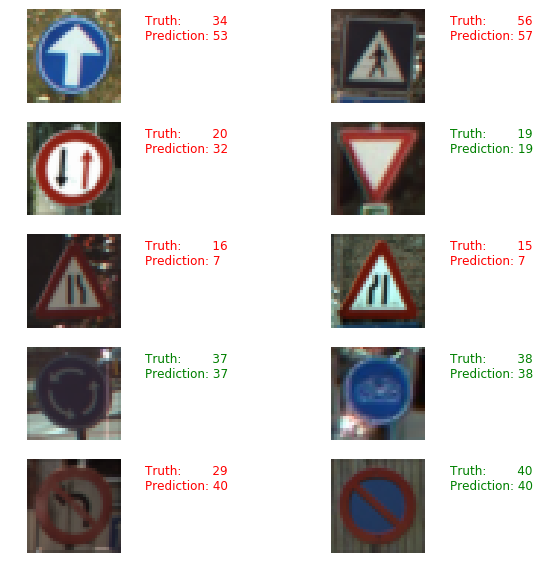

In [20]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])

## 评价模型

In [21]:
# 加载测试集
test_images, test_labels = load_data(test_data_dir)

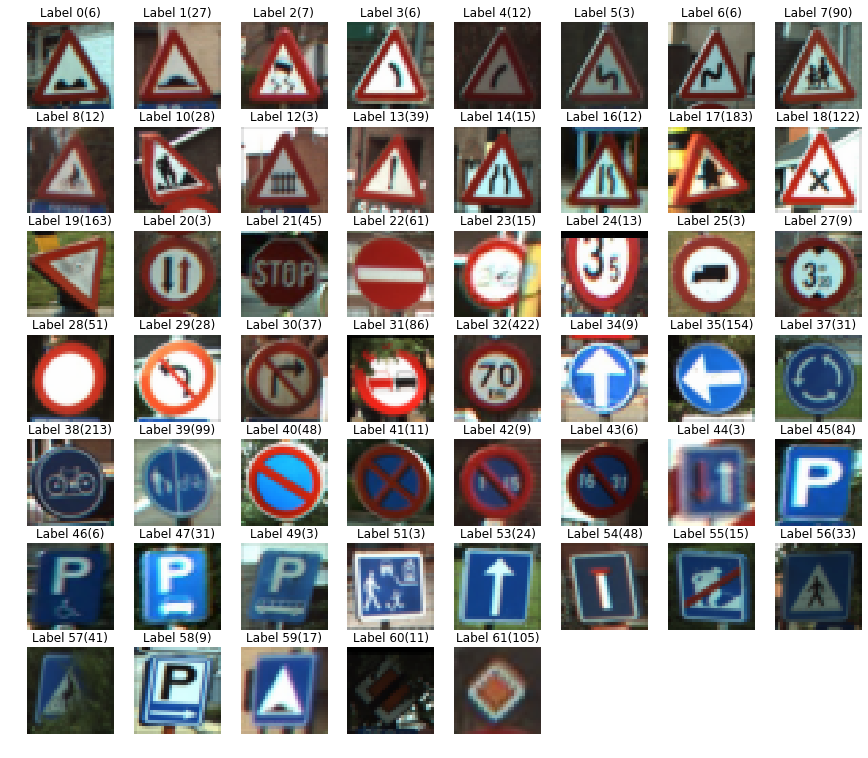

In [22]:
# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                 for image in test_images]
display_images_and_labels(test_images32, test_labels)

In [23]:

# Run predictions against the full test set.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: test_images32})[0]
# Calculate how many matches we got.
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])
accuracy = match_count / len(test_labels)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.569


In [24]:
# Close the session. This will destroy the trained model.
session.close()